# Predictive Modeling
### Using Naive Bayes, Decision Tree, Random Forest, and SVM
- **The first step is to import necessary libraries.**

In [1]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# text processing
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob as tb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models
import scipy.sparse
import pronouncing

# modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# miscellany
import re
import string
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore tensorflow warnings (code from: https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

Using TensorFlow backend.
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/learn-env/lib/p

### Load DataFrame

In [2]:
# uncomment to load
with gzip.open('data/poetry_all_genres_df_edit.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [3]:
df.genre.unique()

array(['beat', 'black_arts_movement', 'black_mountain', 'confessional',
       'fugitive', 'georgian', 'harlem_renaissance', 'imagist',
       'language_poetry', 'modern', 'new_york_school',
       'new_york_school_2nd_generation', 'objectivist', 'romantic',
       'victorian'], dtype=object)

In [4]:
df = df[(df.genre != 'fugitive') & (df.genre != 'georgian')]
df.reset_index(drop=True, inplace=True)
df.genre.unique()

array(['beat', 'black_arts_movement', 'black_mountain', 'confessional',
       'harlem_renaissance', 'imagist', 'language_poetry', 'modern',
       'new_york_school', 'new_york_school_2nd_generation', 'objectivist',
       'romantic', 'victorian'], dtype=object)

In [5]:
df.columns

Index(['poet_url', 'genre', 'poem_url', 'poet', 'title', 'poem_lines',
       'poem_string', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned'],
      dtype='object')

In [6]:
# check out the class balance
df.genre.value_counts(normalize=True)

modern                            0.292276
victorian                         0.146938
romantic                          0.090951
imagist                           0.081353
new_york_school                   0.060329
black_mountain                    0.058729
new_york_school_2nd_generation    0.043876
language_poetry                   0.043876
confessional                      0.040219
black_arts_movement               0.037706
objectivist                       0.036335
harlem_renaissance                0.033821
beat                              0.033592
Name: genre, dtype: float64

In [7]:
# check out the class balance
df.genre.value_counts()

modern                            1279
victorian                          643
romantic                           398
imagist                            356
new_york_school                    264
black_mountain                     257
new_york_school_2nd_generation     192
language_poetry                    192
confessional                       176
black_arts_movement                165
objectivist                        159
harlem_renaissance                 148
beat                               147
Name: genre, dtype: int64

In [ ]:
# Indicies of each class' observations
i_class0 = np.where(y == 0)[0]
i_class1 = np.where(y == 1)[0]

# Number of observations in each class
n_class0 = len(i_class0)
n_class1 = len(i_class1)

# For every observation of class 0, randomly sample from class 1 without replacement
i_class1_downsampled = np.random.choice(i_class1, size=n_class0, replace=False)

# Join together class 0's target vector with the downsampled class 1's target vector
np.hstack((y[i_class0], y[i_class1_downsampled]))

In [ ]:

for genre in df.genre.unique():
    indices = np.where(df.genre == genre)[0]

In [10]:
to_downsample = ['modern', 'victorian', 'romantic', 'imagist', 'new_york_school', 'black_mountain']
to_index = []
for genre in df.genre.unique():
    if genre in to_downsample:
        indices_all = np.where(df.genre == genre)[0]
        indices = np.random.choice(indices_all, size=200, replace=False)
    else:
        indices = np.where(df.genre == genre)[0]
    
    to_index.append(indices)

len(to_index)

13

In [13]:
for i in to_index:
    print(len(i))

147
165
200
176
148
200
192
200
200
192
159
200
200


In [14]:
downsampled_indices = [i for index in to_index for i in index]
len(downsampled_indices)

2379

In [15]:
downsampled_indices[2000:2010]

[3518, 3716, 3539, 3421, 3652, 3383, 3583, 3566, 3391, 3402]

In [17]:
df.shape

(4376, 22)

In [24]:
df_downsampled = df.loc[downsampled_indices]
df_downsampled.shape

(2379, 22)

In [41]:
# check out the class balance
df_downsampled.genre.value_counts()

new_york_school                   200
black_mountain                    200
modern                            200
imagist                           200
romantic                          200
victorian                         200
new_york_school_2nd_generation    192
language_poetry                   192
confessional                      176
black_arts_movement               165
objectivist                       159
harlem_renaissance                148
beat                              147
Name: genre, dtype: int64

In [43]:
# check out the class balance
df_downsampled.genre.value_counts(normalize=True)

new_york_school                   0.084069
black_mountain                    0.084069
modern                            0.084069
imagist                           0.084069
romantic                          0.084069
victorian                         0.084069
new_york_school_2nd_generation    0.080706
language_poetry                   0.080706
confessional                      0.073981
black_arts_movement               0.069357
objectivist                       0.066835
harlem_renaissance                0.062211
beat                              0.061791
Name: genre, dtype: float64

- **Classes are fairly balanced.**

### Create features and target dataframes

In [25]:
# assign a features dataframe
X = df_downsampled[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'avg_syllables_word', 'string_titled', 'string_cleaned']]
# assign a target variable
y = df_downsampled['genre']

### Train-Test Split

In [26]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1784, 8) (1784,)
(595, 8) (595,)


## Baseline model -- tf-idf vectors only

In [27]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train.string_cleaned)
X_test_vec_matrix = vectorizer.transform(X_test.string_cleaned)

In [28]:
# turn our tf-idf vectors into a dataframe so we can better view feature importances
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, columns=vectorizer.get_feature_names())

In [29]:
%%time

# instantiate the naive bayes classifier
bnb_baseline_vec = BernoulliNB()

# fit it to our training set
bnb_baseline_vec.fit(X_train_vec, y_train)

CPU times: user 2.66 s, sys: 353 ms, total: 3.01 s
Wall time: 2.69 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [30]:
%%time

# predict the new document from the testing dataset
y_train_preds_vec = bnb_baseline_vec.predict(X_train_vec)
y_test_preds_vec = bnb_baseline_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
bnb_baseline_vec_acc_train = accuracy_score(y_train, y_train_preds_vec)
bnb_baseline_vec_f1_train = f1_score(y_train, y_train_preds_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_vec_acc_train}')
print(f'F1 score: {bnb_baseline_vec_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_vec_acc_test = accuracy_score(y_test, y_test_preds_vec)
bnb_baseline_vec_f1_test = f1_score(y_test, y_test_preds_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_vec_acc_test}')
print(f'F1 score: {bnb_baseline_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_vec))

-----TRAIN-----
Accuracy: 0.5269058295964125
F1 score: 0.5408320360049632

-----TEST-----
Accuracy: 0.20504201680672268
F1 score: 0.17816891324035106

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.80      0.11      0.19        37
           black_arts_movement       0.00      0.00      0.00        41
                black_mountain       0.12      0.76      0.20        50
                  confessional       0.75      0.07      0.12        44
            harlem_renaissance       0.00      0.00      0.00        37
                       imagist       0.29      0.56      0.38        50
               language_poetry       0.33      0.02      0.04        48
                        modern       0.13      0.16      0.14        50
               new_york_school       0.43      0.18      0.25        50
new_york_school_2nd_genera

- **Not too bad for a baseline. Certainly better than just predicting 'modern', which would give you a 29% accuracy.**
- **That said, it is indeed overpredicting on 'modern'.**

### Feature importances

- **Code modified from: https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes**

In [31]:
# # assign the top 10 feature importances for each class
# metro_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[:, 0].argsort()
# modern_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[1, :].argsort()
# avant_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[2, :].argsort()
# pre1900_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[3, :].argsort()

In [32]:
# # match them up with the proper label
# print(np.take(X_train_vec.columns, metro_class_prob_sorted[:10]))
# print(np.take(X_train_vec.columns, modern_class_prob_sorted[:10]))
# print(np.take(X_train_vec.columns, avant_class_prob_sorted[:10]))
# print(np.take(X_train_vec.columns, pre1900_class_prob_sorted[:10]))

## Baseline model -- vectors + numerical data

- **Create dataframe.**

In [33]:
# separate out our numerical data
X_train_nums = X_train.drop(columns=['string_titled', 'string_cleaned'])
X_test_nums = X_test.drop(columns=['string_titled', 'string_cleaned'])

- **Scale and combine.**

In [34]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

In [35]:
# combine the numerical and vector dataframes for both train and test sets
X_train_combo = pd.concat([X_train_scaled_df, X_train_vec], axis=1)
X_test_combo = pd.concat([X_test_scaled_df, X_test_vec], axis=1)

- **Model.**

In [36]:
%%time

# instantiate the naive bayes classifier
bnb_baseline_combo = BernoulliNB()

# fit it to our training set
bnb_baseline_combo.fit(X_train_combo, y_train)

CPU times: user 5.33 s, sys: 887 ms, total: 6.22 s
Wall time: 5.96 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [37]:
%%time

# predict the new document from the testing dataset
y_train_preds_combo = bnb_baseline_combo.predict(X_train_combo)
y_test_preds_combo = bnb_baseline_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
bnb_baseline_combo_acc_train = accuracy_score(y_train, y_train_preds_combo)
bnb_baseline_combo_f1_train = f1_score(y_train, y_train_preds_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_combo_acc_train}')
print(f'F1 score: {bnb_baseline_combo_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_combo_acc_test = accuracy_score(y_test, y_test_preds_combo)
bnb_baseline_combo_f1_test = f1_score(y_test, y_test_preds_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_combo_acc_test}')
print(f'F1 score: {bnb_baseline_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_combo))

-----TRAIN-----
Accuracy: 0.5269058295964125
F1 score: 0.5406723873236532

-----TEST-----
Accuracy: 0.20672268907563024
F1 score: 0.18034679546531937

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.80      0.11      0.19        37
           black_arts_movement       0.00      0.00      0.00        41
                black_mountain       0.12      0.76      0.20        50
                  confessional       0.75      0.07      0.12        44
            harlem_renaissance       0.00      0.00      0.00        37
                       imagist       0.30      0.56      0.39        50
               language_poetry       0.33      0.02      0.04        48
                        modern       0.14      0.18      0.16        50
               new_york_school       0.43      0.18      0.25        50
new_york_school_2nd_genera

- **Practically the same result.**

### Feature importances

In [38]:
# # assign the top 10 feature importances for each class
# metro_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[:, 0].argsort()
# modern_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[1, :].argsort()
# avant_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[2, :].argsort()
# pre1900_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[3, :].argsort()

In [39]:
# # match them up with the proper label
# print(np.take(X_train_combo.columns, metro_class_prob_sorted[:10]))
# print(np.take(X_train_combo.columns, modern_class_prob_sorted[:10]))
# print(np.take(X_train_combo.columns, avant_class_prob_sorted[:10]))
# print(np.take(X_train_combo.columns, pre1900_class_prob_sorted[:10]))

- **Some engineered features made it into this one.**

## Decision Tree -- tf-idf vectors only

- **I'll first take a quick look at cross validation scores.**

In [44]:
# instantiate the naive bayes classifier
tree_vec = DecisionTreeClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(tree_vec, X_train_vec, y_train, cv=10, n_jobs=-1)

array([0.16759777, 0.2122905 , 0.22905028, 0.21787709, 0.16853933,
       0.19662921, 0.16292135, 0.14606742, 0.17977528, 0.1741573 ])

- **Naive Bayes performs better.**

## Decision Tree -- vectors and numerical data

- **Look at cross validation scores.**

In [45]:
# instantiate the decision classifier
tree_combo = DecisionTreeClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(tree_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.25139665, 0.19553073, 0.20670391, 0.22905028, 0.24157303,
       0.21348315, 0.21348315, 0.15730337, 0.17977528, 0.17977528])

- **A notable improvement, so I'll fit a model.**

In [46]:
%%time

# instantiate the model
tree_combo = DecisionTreeClassifier(class_weight='balanced', random_state=1)

# fit to the training set
tree_combo.fit(X_train_combo, y_train)

CPU times: user 4.78 s, sys: 604 ms, total: 5.38 s
Wall time: 5.43 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [47]:
%%time

# predict class for the train and test sets
y_train_preds_tree_combo = tree_combo.predict(X_train_combo)
y_test_preds_tree_combo = tree_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
tree_combo_acc_train = accuracy_score(y_train, y_train_preds_tree_combo)
tree_combo_f1_train = f1_score(y_train, y_train_preds_tree_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {tree_combo_acc_train}')
print(f'F1 score: {tree_combo_f1_train}')

# print out accuracy and f1 scores for test set
tree_combo_acc_test = accuracy_score(y_test, y_test_preds_tree_combo)
tree_combo_f1_test = f1_score(y_test, y_test_preds_tree_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {tree_combo_acc_test}')
print(f'F1 score: {tree_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_tree_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_tree_combo))

-----TRAIN-----
Accuracy: 1.0
F1 score: 1.0

-----TEST-----
Accuracy: 0.18319327731092436
F1 score: 0.17946412600124742

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.11      0.08      0.09        37
           black_arts_movement       0.17      0.12      0.14        41
                black_mountain       0.18      0.20      0.19        50
                  confessional       0.11      0.11      0.11        44
            harlem_renaissance       0.16      0.19      0.17        37
                       imagist       0.16      0.14      0.15        50
               language_poetry       0.09      0.08      0.08        48
                        modern       0.13      0.10      0.11        50
               new_york_school       0.26      0.30      0.28        50
new_york_school_2nd_generation       0.14      0.17     

- **This is definitely better than our Naive Bayes model.**
    - **It predicts 'modern' a lot less.**
    - **Predictions seem fairly evenly spread.**
    - **Has trouble predicting avant-garde.**
    
### Feature importances

In [48]:
# create a dictionary
tree_features = dict(zip(X_train_combo.columns, tree_combo.feature_importances_))

# sort dictionary
tree_features = dict(sorted(tree_features.items(), key=lambda x: x[1], reverse=True)[:10])
tree_features

{'avg_syllables_word': 0.05312715829333155,
 'sentiment_polarity_score': 0.046932103697271924,
 'avg_len_line': 0.045546813477621885,
 'num_end_rhymes': 0.044260667805098665,
 'num_lines': 0.03935018484518458,
 'sentiment_subjectivity_score': 0.02823544095311568,
 'black': 0.011197957699761401,
 'know': 0.010893595989132256,
 'one': 0.010665244385680018,
 'come': 0.00899730156084741}

- **Mostly engineered features on top.**

## Random Forest -- tf-idf vectors only

- **First, I'll take a quick look at cross validation scores.**

In [49]:
# instantiate the naive bayes classifier
forest_vec = RandomForestClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(forest_vec, X_train_vec, y_train, cv=10, n_jobs=-1)

array([0.25698324, 0.33519553, 0.34078212, 0.30167598, 0.29213483,
       0.34831461, 0.29775281, 0.28089888, 0.28651685, 0.30898876])

- **Compare that to vectors plus numerical data.**

## Random Forest -- vectors and numerical data

- **Take a quick look at cross validation scores.**

In [50]:
# instantiate the decision classifier
forest_combo = RandomForestClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(forest_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.36871508, 0.37430168, 0.38547486, 0.36312849, 0.31460674,
       0.40449438, 0.34269663, 0.28089888, 0.33707865, 0.31460674])

- **Including engineered features seems more promising, so I'll move ahead with this one.**

In [51]:
%%time

# instantiate the model
forest_combo = RandomForestClassifier(class_weight='balanced', random_state=1)

# fit to the training set
forest_combo.fit(X_train_combo, y_train)

CPU times: user 9.17 s, sys: 616 ms, total: 9.79 s
Wall time: 9.87 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [52]:
%%time

# predict class for the train and test sets
y_train_preds_forest_combo = forest_combo.predict(X_train_combo)
y_test_preds_forest_combo = forest_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
forest_combo_acc_train = accuracy_score(y_train, y_train_preds_forest_combo)
forest_combo_f1_train = f1_score(y_train, y_train_preds_forest_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {forest_combo_acc_train}')
print(f'F1 score: {forest_combo_f1_train}')

# print out accuracy and f1 scores for test set
forest_combo_acc_test = accuracy_score(y_test, y_test_preds_forest_combo)
forest_combo_f1_test = f1_score(y_test, y_test_preds_forest_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {forest_combo_acc_test}')
print(f'F1 score: {forest_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_forest_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_forest_combo))

-----TRAIN-----
Accuracy: 1.0
F1 score: 1.0

-----TEST-----
Accuracy: 0.3546218487394958
F1 score: 0.3490325106232763

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.57      0.11      0.18        37
           black_arts_movement       0.39      0.22      0.28        41
                black_mountain       0.31      0.48      0.38        50
                  confessional       0.52      0.30      0.38        44
            harlem_renaissance       0.59      0.27      0.37        37
                       imagist       0.23      0.46      0.31        50
               language_poetry       0.42      0.40      0.41        48
                        modern       0.23      0.22      0.22        50
               new_york_school       0.36      0.36      0.36        50
new_york_school_2nd_generation       0.33      0.29      0

- **Good results! So I'll look at a confusion matrix visualization.**

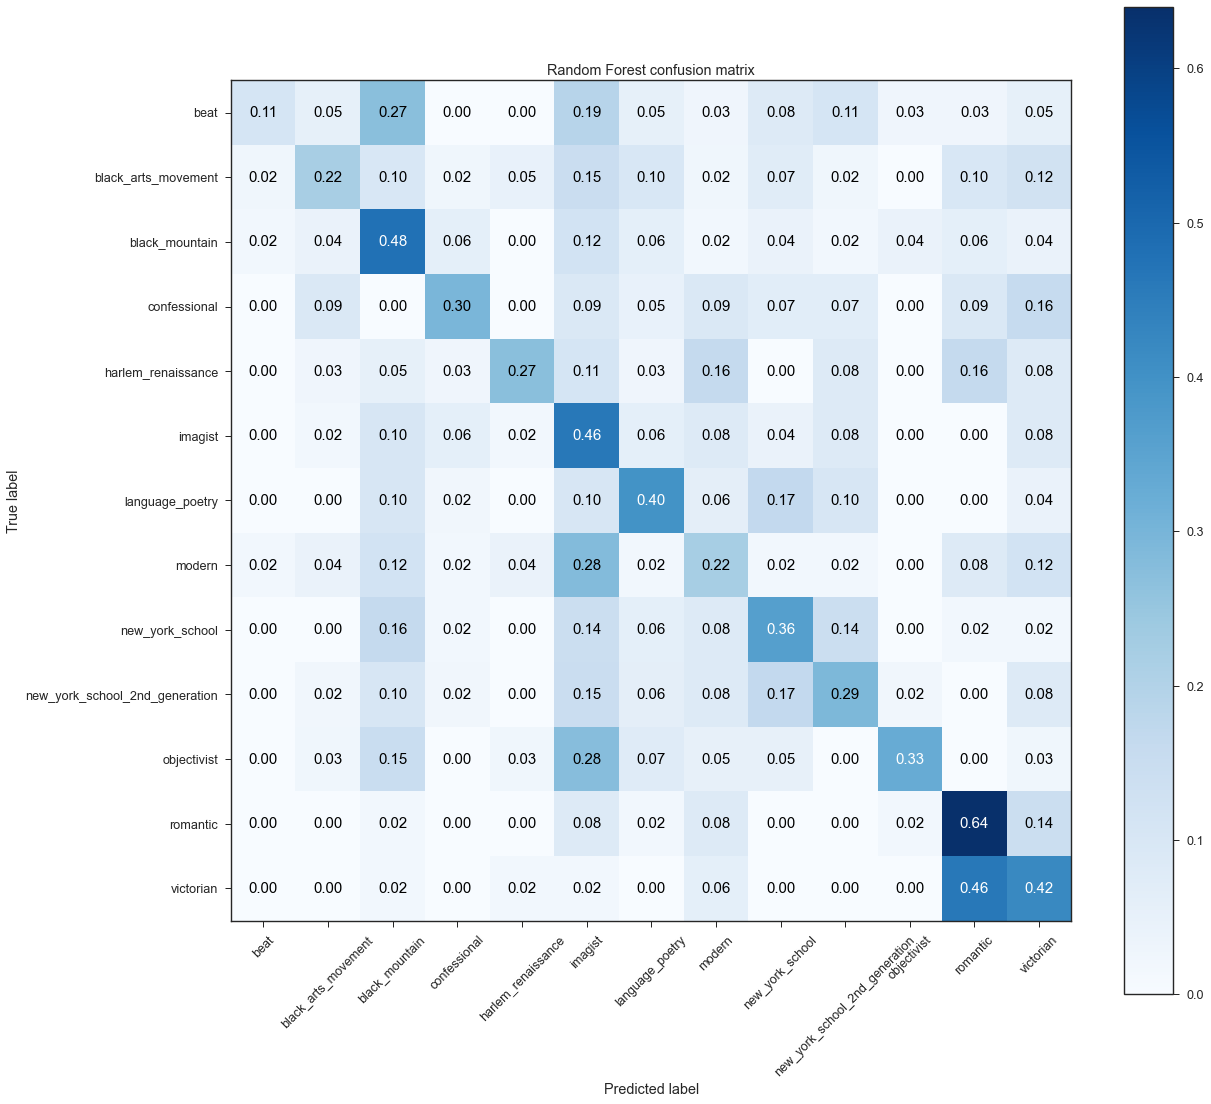

In [53]:
cm = confusion_matrix(y_test, y_test_preds_forest_combo)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Random Forest confusion matrix',
                          cmap=plt.cm.Blues);

- **Big strides made on all categories here.**
- **Looks like some improvement could be made for avant-garde and metropolitan.**

### Feature importances

In [54]:
# create a dictionary
forest_features = dict(zip(X_train_combo.columns, forest_combo.feature_importances_))

# sort dictionary
forest_features = dict(sorted(forest_features.items(), key=lambda x: x[1], reverse=True)[:10])
forest_features

{'avg_len_line': 0.010931704709778271,
 'num_end_rhymes': 0.009455661524878011,
 'avg_syllables_word': 0.008591952552760863,
 'sentiment_polarity_score': 0.007797449045050464,
 'num_lines': 0.007489363626092113,
 'sentiment_subjectivity_score': 0.006689962312956047,
 'love': 0.0032051883930807566,
 'come': 0.0031777975624142007,
 'one': 0.003094692461105772,
 'say': 0.0027577714967626475}

- **Lots of engineered features here, and some surprise words.**
- **'Heart' appeared to be mostly within pre-1900 poetry, so that probably explains it's importance.**

## SVM Model - tf-idf vectors only

In [55]:
%%time

# instantiate the model
svm_vec = SVC(kernel='linear', class_weight='balanced')

# fit to the training set
svm_vec.fit(X_train_vec, y_train)

CPU times: user 3min 17s, sys: 1.28 s, total: 3min 18s
Wall time: 3min 20s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [56]:
%%time

# predict class for the train and test sets
y_train_preds_svm_vec = svm_vec.predict(X_train_vec)
y_test_preds_svm_vec = svm_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
svm_vec_acc_train = accuracy_score(y_train, y_train_preds_svm_vec)
svm_vec_f1_train = f1_score(y_train, y_train_preds_svm_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_vec_acc_train}')
print(f'F1 score: {svm_vec_f1_train}')

# print out accuracy and f1 scores for test set
svm_vec_acc_test = accuracy_score(y_test, y_test_preds_svm_vec)
svm_vec_f1_test = f1_score(y_test, y_test_preds_svm_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_vec_acc_test}')
print(f'F1 score: {svm_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_vec))

-----TRAIN-----
Accuracy: 0.9977578475336323
F1 score: 0.9977596581374388

-----TEST-----
Accuracy: 0.4756302521008403
F1 score: 0.47684670738799945

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.45      0.35      0.39        37
           black_arts_movement       0.47      0.39      0.43        41
                black_mountain       0.43      0.48      0.45        50
                  confessional       0.44      0.45      0.45        44
            harlem_renaissance       0.65      0.41      0.50        37
                       imagist       0.46      0.50      0.48        50
               language_poetry       0.38      0.48      0.43        48
                        modern       0.30      0.38      0.34        50
               new_york_school       0.51      0.48      0.49        50
new_york_school_2nd_generat

### Confusion matrix visualization

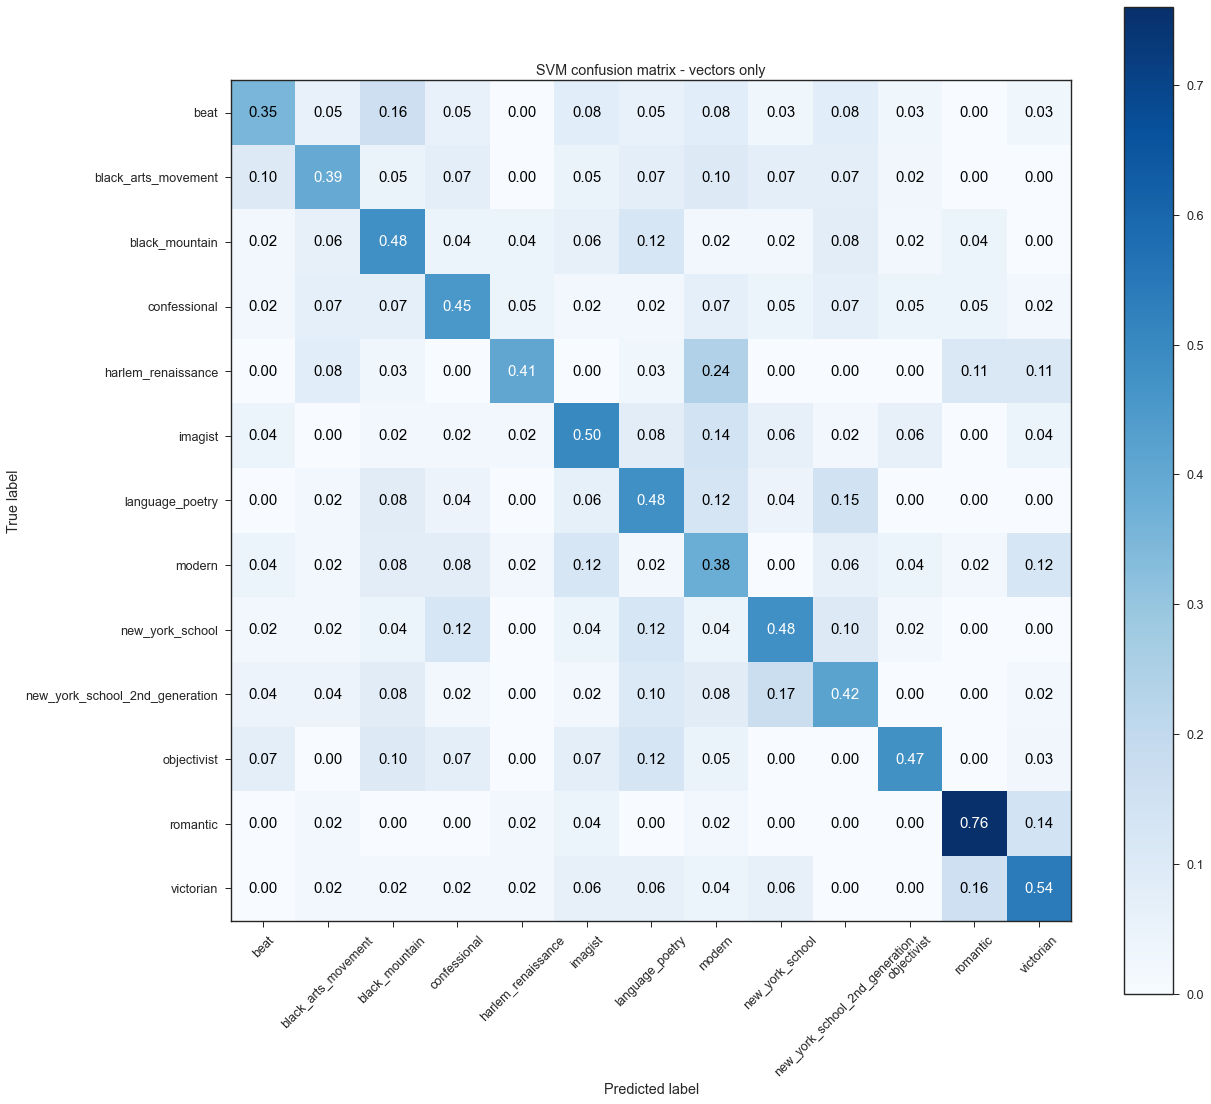

In [57]:
cm = confusion_matrix(y_test, y_test_preds_svm_vec)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix - vectors only',
                          cmap=plt.cm.Blues);

### Feature importances
- **Code credit: 'https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn'**

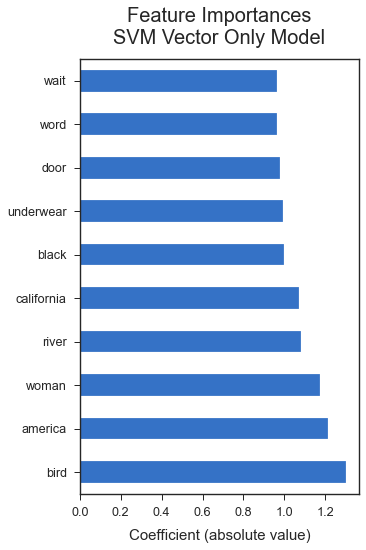

In [58]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Vector Only Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_vec.coef_[0]), index=X_train_vec.columns).nlargest(10).plot(kind='barh');

- **Quite a bump! very overfit, but I'll see if it works any better with our combo dataframes.**

## SVM - vectors + numerical data

In [59]:
%%time

# instantiate the model
svm_combo = SVC(kernel='linear', class_weight='balanced')

# fit to the training set
svm_combo.fit(X_train_combo, y_train)

CPU times: user 3min 7s, sys: 1.42 s, total: 3min 8s
Wall time: 3min 10s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [60]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo = svm_combo.predict(X_train_combo)
y_test_preds_svm_combo = svm_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train = accuracy_score(y_train, y_train_preds_svm_combo)
svm_combo_f1_train = f1_score(y_train, y_train_preds_svm_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train}')
print(f'F1 score: {svm_combo_f1_train}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test = accuracy_score(y_test, y_test_preds_svm_combo)
svm_combo_f1_test = f1_score(y_test, y_test_preds_svm_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test}')
print(f'F1 score: {svm_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo))

-----TRAIN-----
Accuracy: 0.9792600896860987
F1 score: 0.9792469144101369

-----TEST-----
Accuracy: 0.4504201680672269
F1 score: 0.44450536835954324

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.38      0.30      0.33        37
           black_arts_movement       0.37      0.27      0.31        41
                black_mountain       0.42      0.62      0.50        50
                  confessional       0.43      0.36      0.40        44
            harlem_renaissance       0.65      0.35      0.46        37
                       imagist       0.54      0.44      0.48        50
               language_poetry       0.38      0.44      0.41        48
                        modern       0.30      0.30      0.30        50
               new_york_school       0.45      0.66      0.54        50
new_york_school_2nd_generat

### Confusion matrix visualization

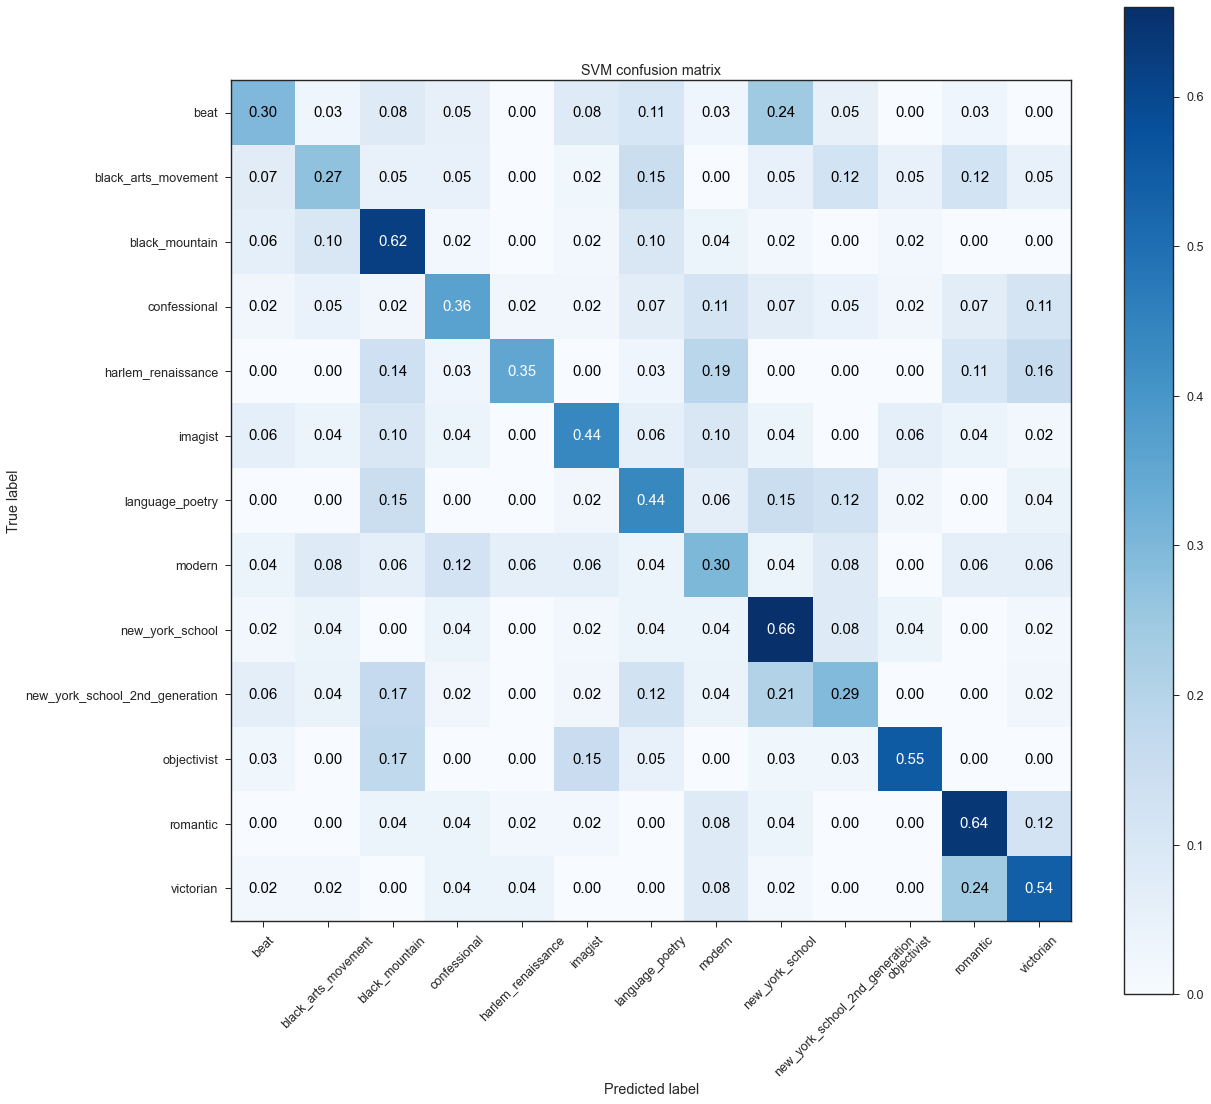

In [61]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

- **Still overfit but nearly a 10% increase in the test predictions!**

### Feature importances

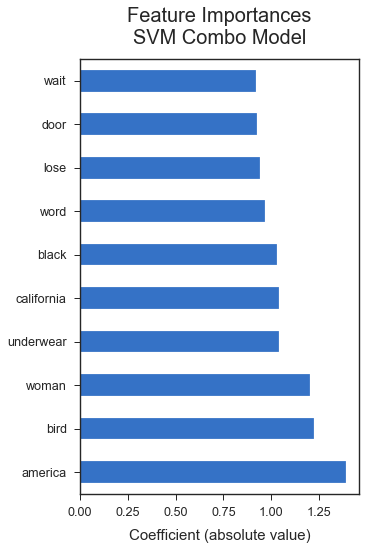

In [62]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

- **Mostly surprising words, other than maybe 'get', which was a top 5 frequent word.**
- **Nice to see an engineered feature in the top spot.**

### Changing C value and class weight.

In [63]:
%%time

# instantiate the model
svm_combo2 = SVC(C=2, kernel='linear', class_weight='balanced')

# fit to the training set
svm_combo2.fit(X_train_combo, y_train)

CPU times: user 3min 23s, sys: 2.1 s, total: 3min 25s
Wall time: 3min 27s


SVC(C=2, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [64]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo2 = svm_combo2.predict(X_train_combo)
y_test_preds_svm_combo2 = svm_combo2.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train2 = accuracy_score(y_train, y_train_preds_svm_combo2)
svm_combo_f1_train2 = f1_score(y_train, y_train_preds_svm_combo2, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train2}')
print(f'F1 score: {svm_combo_f1_train2}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test2 = accuracy_score(y_test, y_test_preds_svm_combo2)
svm_combo_f1_test2 = f1_score(y_test, y_test_preds_svm_combo2, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test2}')
print(f'F1 score: {svm_combo_f1_test2}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo2, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo2))

-----TRAIN-----
Accuracy: 1.0
F1 score: 1.0

-----TEST-----
Accuracy: 0.4672268907563025
F1 score: 0.46260078095547186

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.41      0.32      0.36        37
           black_arts_movement       0.36      0.24      0.29        41
                black_mountain       0.39      0.60      0.48        50
                  confessional       0.38      0.34      0.36        44
            harlem_renaissance       0.65      0.41      0.50        37
                       imagist       0.60      0.52      0.56        50
               language_poetry       0.33      0.42      0.37        48
                        modern       0.35      0.30      0.32        50
               new_york_school       0.52      0.66      0.58        50
new_york_school_2nd_generation       0.39      0.35      

### Confusion matrix visualization

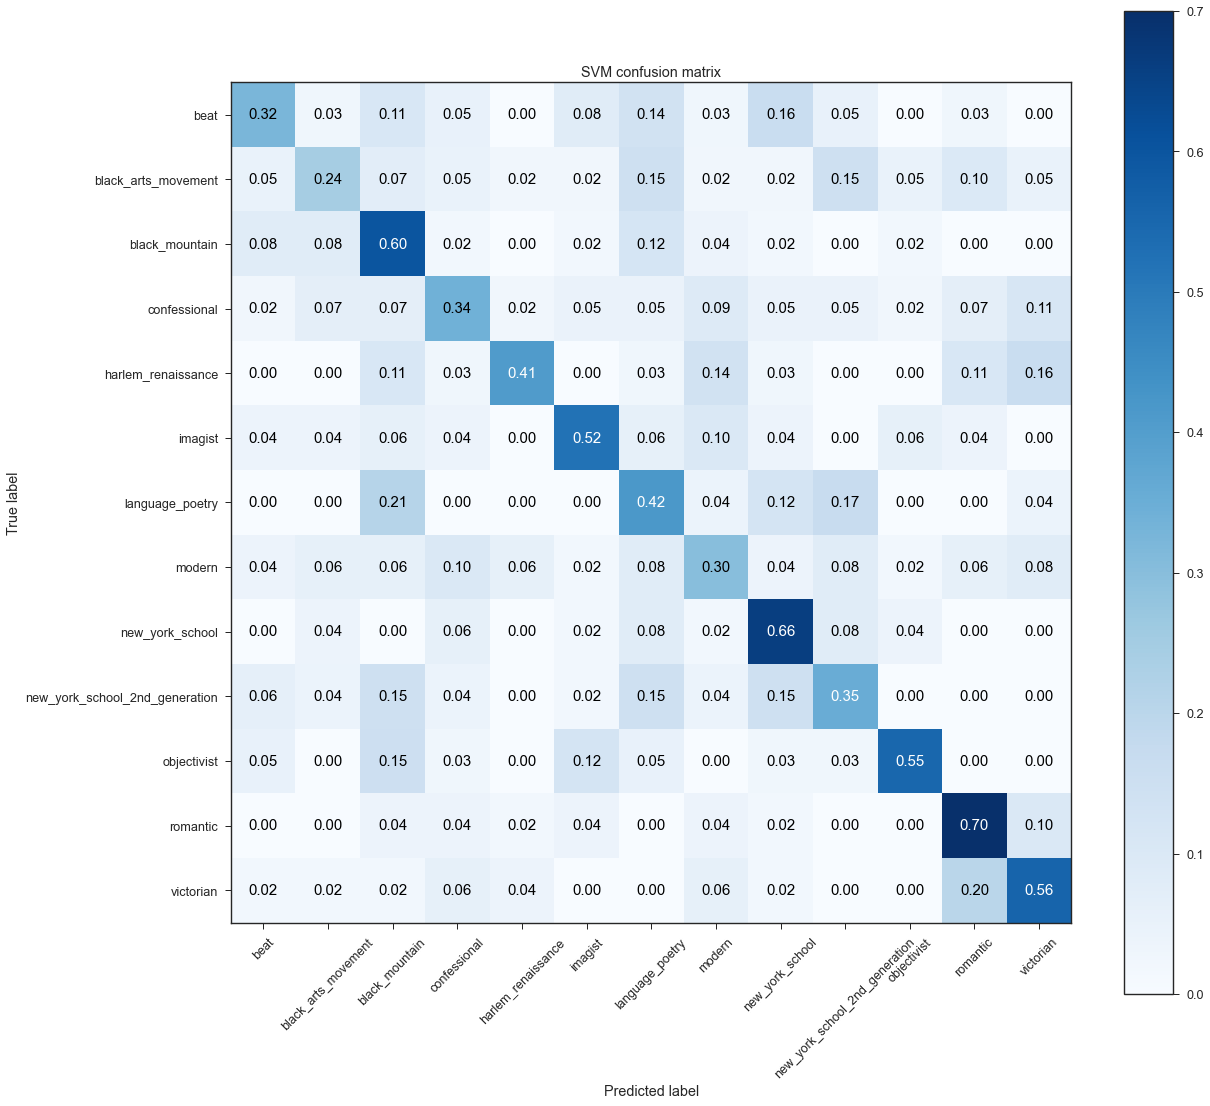

In [65]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo2)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

### Feature importances

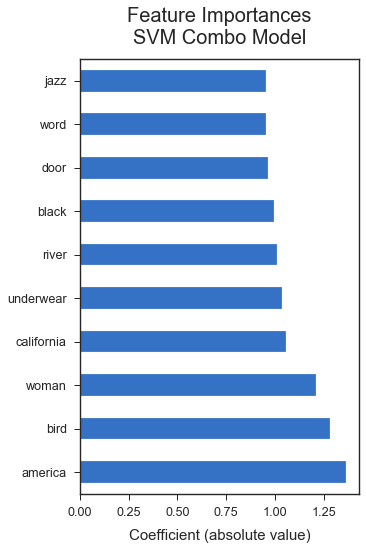

In [66]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo2.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

- **The number of words per line dropped down, but still in the top ten.**

# Modeling conclusions
- **Form/structure is important for prediction (especially Random Forest models).**
    - **Further exploration desired:**
        - **Other types of rhyme**
        - **Use of line breaks, tabs, and spacing**
        - **Topic modeling**
- **SVM relies mostly on vocabulary.**
    - **Further exploration desired:**
        - **Word embeddings (self-trained and pre-trained)**
        - **POS tagging**
- **SVM is the best model!**

- **Mostly surprising words, other than maybe 'get', which was a top 5 frequent word.**
- **Nice to see an engineered feature in the top spot.**

### Changing C value and class weight.

In [62]:
%%time

# instantiate the model
svm_combo2b = SVC(C=1.5, kernel='linear', class_weight='balanced',
#                   max_iter=100,
#                   decision_function_shape='ovo',
                  random_state=42)

# fit to the training set
svm_combo2b.fit(X_train_combo, y_train)

CPU times: user 13min 3s, sys: 4.55 s, total: 13min 8s
Wall time: 13min 13s


SVC(C=1.5, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [63]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo2b = svm_combo2b.predict(X_train_combo)
y_test_preds_svm_combo2b = svm_combo2b.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train2b = accuracy_score(y_train, y_train_preds_svm_combo2b)
svm_combo_f1_train2b = f1_score(y_train, y_train_preds_svm_combo2b, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train2b}')
print(f'F1 score: {svm_combo_f1_train2b}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test2b = accuracy_score(y_test, y_test_preds_svm_combo2b)
svm_combo_f1_test2b = f1_score(y_test, y_test_preds_svm_combo2b, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test2b}')
print(f'F1 score: {svm_combo_f1_test2b}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo2b, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo2b))

-----TRAIN-----
Accuracy: 0.9616087751371115
F1 score: 0.9612647981911966

-----TEST-----
Accuracy: 0.5703839122486288
F1 score: 0.5542403216996467

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.46      0.30      0.36        37
           black_arts_movement       0.50      0.24      0.33        41
                black_mountain       0.42      0.47      0.44        64
                  confessional       0.41      0.16      0.23        44
            harlem_renaissance       0.67      0.27      0.38        37
                       imagist       0.55      0.58      0.57        89
               language_poetry       0.47      0.29      0.36        48
                        modern       0.59      0.77      0.67       320
               new_york_school       0.49      0.70      0.57        66
new_york_school_2nd_generati

### Confusion matrix visualization

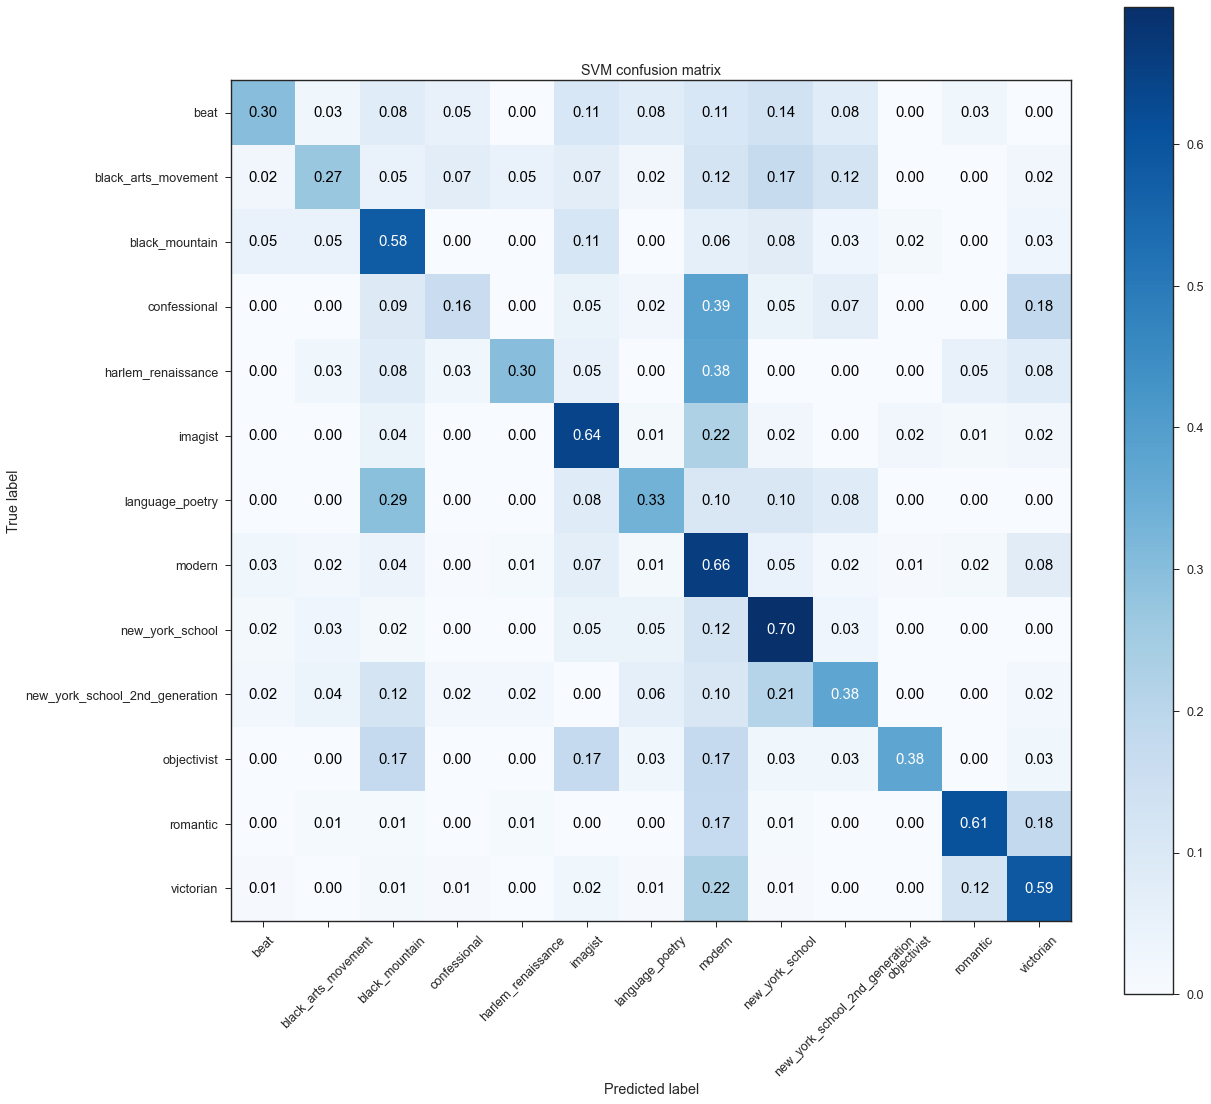

In [61]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo2b)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

### Feature importances

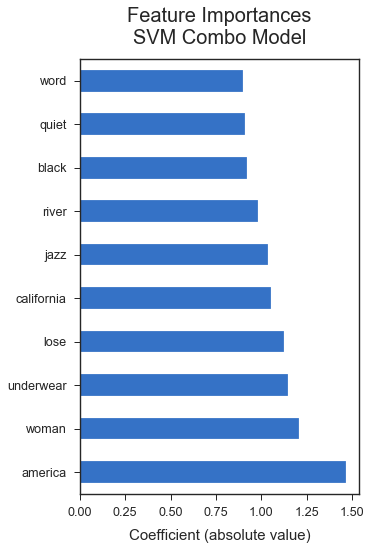

In [52]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo2b.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

In [69]:
# rec system libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import matutils, models
from gensim.utils import simple_preprocess

In [70]:
# load the model
model = Doc2Vec.load('data/doc2vec.model')

In [71]:
len(model[0])

100

In [72]:
model.docvecs[4375]

array([ 1.2006652 ,  0.08307341,  0.07383984, -3.7577698 , -1.3732673 ,
       -1.9492179 , -0.51855606,  1.2757812 , -2.1541429 ,  3.6966357 ,
       -0.9324427 , -3.3933728 ,  2.2591443 ,  2.1146212 , -0.8617075 ,
        1.9893605 ,  1.5804762 , -2.7629943 , -3.7851126 , -1.65619   ,
       -3.0771718 , -0.3890964 ,  2.676029  , -3.1462984 , -2.6133223 ,
       -5.2887487 ,  2.533953  , -2.0680223 , -1.4912119 ,  0.85219496,
       -2.4538805 , -1.968039  , -2.1103768 , -0.65240467, -3.256561  ,
       -0.22674862,  2.5130308 ,  1.5527182 , -0.7872084 ,  0.7285329 ,
       -0.7509936 ,  2.138676  ,  1.6633475 , -4.313129  ,  5.2023277 ,
        1.6293415 ,  1.5118138 , -4.0869627 ,  0.6913048 , -3.5921793 ,
        4.4061847 , -0.24334763,  0.9060332 , -0.96803534, -0.6498659 ,
       -1.4631542 ,  1.2633619 , -1.8299843 , -2.6928277 ,  0.9119264 ,
       -2.4688904 , -4.9157147 , -0.19808227,  0.21045764, -3.4096267 ,
       -2.8473542 ,  4.5900426 , -5.4284616 , -2.899884  , -0.95

In [73]:
df.tail()

,poet_url,genre,poem_url,poet,title,poem_lines,poem_string,clean_lines,num_lines,num_words,...,sentiment_polarity,sentiment_subjectivity_score,num_end_rhymes,end_rhyme_ratio,end_rhyme,num_syllables,avg_syllables_word,lines_titled,string_titled,string_cleaned
4371,https://www.poetryfoundation.org/poets/john-greenleaf-whittier,victorian,https://www.poetryfoundation.org/poems/45490/snow-bound-a-winter-idyl,John Greenleaf Whittier,Snow-Bound: A Winter Idyl,"[The sun that brief December day , Rose cheerless over hills of gray, , And, darkly circled, gave at noon , A sadder light than waning moon. , Slo...","The sun that brief December day \nRose cheerless over hills of gray, \nAnd, darkly circled, gave at noon \nA sadder light than waning moon. \nSlow...","[The sun that brief December day, Rose cheerless over hills of gray,, And, darkly circled, gave at noon, A sadder light than waning moon., Slow tr...",90,700,...,positive,0.502497,50,4.199472,1,5632,1.209103,"[Snow-Bound: A Winter Idyl, The sun that brief December day, Rose cheerless over hills of gray,, And, darkly circled, gave at noon, A sadder light...","Snow-Bound: A Winter Idyl The sun that brief December day Rose cheerless over hills of gray, And, darkly circled, gave at noon A sadder light than...",snow bound winter idyl sun brief december day rise cheerless hill gray darkly circle give noon sadder light wan moon slow trace thicken sky mute o...
4372,https://www.poetryfoundation.org/poets/john-greenleaf-whittier,victorian,https://www.poetryfoundation.org/poems/45491/telling-the-bees,John Greenleaf Whittier,Telling the Bees,"[Here is the place; right over the hill , Runs the path I took; , You can see the gap in the old wall still, , And the stepping-stones in th...","Here is the place; right over the hill \n Runs the path I took; \nYou can see the gap in the old wall still, \n And the stepping-stones in the...","[Here is the place; right over the hill, Runs the path I took;, You can see the gap in the old wall still,, And the stepping-stones in the shallow...",56,393,...,negative,0.388294,36,0.642857,1,426,1.083969,"[Telling the Bees, Here is the place; right over the hill, Runs the path I took;, You can see the gap in the old wall still,, And the stepping-sto...","Telling the Bees Here is the place; right over the hill Runs the path I took; You can see the gap in the old wall still, And the stepping-stones i...",tell bee place right hill run path take see gap old wall still step stone shallow brook house gate red bar poplar tall barn brown length cattle ya...
4373,https://www.poetryfoundation.org/poets/john-greenleaf-whittier,victorian,https://www.poetryfoundation.org/poems/45492/what-the-birds-said,John Greenleaf Whittier,What the Birds Said,"[The birds against the April wind\r, Flew northward, singing as they flew;\r, They sang, “The land we leave behind\r, Has swords for corn-blad...","The birds against the April wind\r\n Flew northward, singing as they flew;\r\nThey sang, “The land we leave behind\r\n Has swords for corn-blade...","[The birds against the April wind, Flew northward, singing as they flew;, They sang, “The land we leave behind, Has swords for corn-blades, blood ...",44,279,...,negative,0.569830,18,0.409091,1,326,1.168459,"[What the Birds Said, The birds against the April wind, Flew northward, singing as they flew;, They sang, “The land we leave behind, Has swords fo...","What the Birds Said The birds against the April wind Flew northward, singing as they flew; They sang, “The land we leave behind Has swords for cor...",bird say bird april wind flew northward sing flew sang land leave behind sword corn blade blood dew wild bird fly south saw heard gaze saw mortar ...
4374,https://www.poetryfoundation.org/poets/john-greenleaf-whittier,victorian,https://www.poetryfoundation.org/poems/45493/the-worship-of-nature,John Greenleaf Whittier,The Worship of Nature,"[The harp at Nature’s advent strung , Has never ceased to play; , The song the stars of morning sung

In [74]:
df['doc2vec'] = [model[i] for i in range(len(df))]
df.doc2vec.head()

0    [2.2810318, -1.3713742, -2.2196689, -5.0615764, 0.3864901, 0.41665703, 1.3406408, -1.5597857, -0.31412253, -0.4657635, -2.411453, 0.08069745, 1.33...
1    [2.1657145, -2.0169647, 2.2267005, -2.0562868, -1.5337021, -3.544704, 0.543327, 1.4363956, -3.0137055, 1.9207215, 1.6236316, -4.414039, 1.7481873,...
2    [-0.8471292, -3.5684974, 1.7660245, -0.7075871, 0.1878668, -2.0000925, 3.5216043, 1.8281693, 3.78491, 1.7794362, 1.1803681, 0.5493797, 4.158774, -...
3    [-5.168643, -1.8557563, 1.6146945, -3.8942952, 1.6658205, -0.19298406, 1.7390785, -1.5401896, 3.028075, 0.37988093, -1.8792233, -1.4851906, -1.698...
4    [-1.2178899, 1.3043916, -2.8433595, -2.121003, 3.0231776, 0.6782006, 2.7962484, 2.6654553, 2.2535207, 2.3527656, 0.16284443, -2.3561792, 0.7265119...
Name: doc2vec, dtype: object

In [75]:
model.dm_tag_count

1

In [90]:
df_vecs = pd.DataFrame(np.vstack(model[i] for i in range(len(df))))
df_vecs.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.281032,-1.371374,-2.219669,-5.061576,0.386490,0.416657,1.340641,-1.559786,-0.314123,-0.465764,...,0.914341,-0.042474,-1.413320,3.378504,-0.387815,-0.327874,-0.029154,1.119749,2.482635,-2.202907
1,2.165715,-2.016965,2.226701,-2.056287,-1.533702,-3.544704,0.543327,1.436396,-3.013705,1.920722,...,-2.519491,-1.564618,2.388425,-3.334627,-2.866033,2.925122,-1.246679,0.222634,-2.713806,-0.705287
2,-0.847129,-3.568497,1.766024,-0.707587,0.187867,-2.000093,3.521604,1.828169,3.784910,1.779436,...,-1.003638,1.122231,3.063076,-0.517507,-0.472288,1.351467,-1.488940,1.042941,0.121341,0.073162
3,-5.168643,-1.855756,1.614694,-3.894295,1.665820,-0.192984,1.739079,-1.540190,3.028075,0.379881,...,-0.311557,-3.424692,0.067995,3.414546,0.398550,-0.784360,-2.558453,3.444434,-1.373973,-2.202393
4,-1.217890,1.304392,-2.843359,-2.121003,3.023178,0.678201,2.796248,2.665455,2.253521,2.352766,...,-0.483795,1.881845,-1.505026,-1.484471,-2.559262,-1.319453,-0.751955,2.392272,-0.071207,-1.690263


In [91]:
df_vecs_downsampled = df_vecs.loc[downsampled_indices]

In [92]:
df_vecs_downsampled.shape

(2379, 100)

In [93]:
# assign a features dataframe
X2 = pd.concat([df_downsampled[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'avg_syllables_word']], df_vecs_downsampled], axis=1)
# assign a target variable
y2 = df_downsampled['genre']

In [97]:
# train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=y2, random_state=42)
print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

(1784, 106) (1784,)
(595, 106) (595,)


In [98]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our numerical data
X_train_scaled = scaler.fit_transform(X_train2)
X_test_scaled = scaler.transform(X_test2)

In [102]:
%%time

# instantiate the model
svm_doc2vec = SVC(C=1, kernel='linear', class_weight='balanced')

# fit to the training set
svm_doc2vec.fit(X_train_scaled, y_train2)

CPU times: user 412 ms, sys: 3.82 ms, total: 416 ms
Wall time: 421 ms


SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [103]:
%%time

# predict class for the train and test sets
y_train_preds_svm_doc2vec = svm_doc2vec.predict(X_train_scaled)
y_test_preds_svm_doc2vec = svm_doc2vec.predict(X_test_scaled)

# print out accuracy and f1 scores for train set
svm_doc2vec_acc_train = accuracy_score(y_train2, y_train_preds_svm_doc2vec)
svm_doc2vec_f1_train = f1_score(y_train2, y_train_preds_svm_doc2vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_doc2vec_acc_train}')
print(f'F1 score: {svm_doc2vec_f1_train}')

# print out accuracy and f1 scores for test set
svm_doc2vec_acc_test = accuracy_score(y_test2, y_test_preds_svm_doc2vec)
svm_doc2vec_f1_test = f1_score(y_test2, y_test_preds_svm_doc2vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_doc2vec_acc_test}')
print(f'F1 score: {svm_doc2vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test2, y_test_preds_svm_doc2vec, target_names=list(y2.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test2, y_test_preds_svm_doc2vec))

-----TRAIN-----
Accuracy: 0.672645739910314
F1 score: 0.6728293680562109

-----TEST-----
Accuracy: 0.3563025210084034
F1 score: 0.354694970989517

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.16      0.22      0.18        37
           black_arts_movement       0.29      0.32      0.30        41
                black_mountain       0.35      0.34      0.34        50
                  confessional       0.25      0.32      0.28        44
            harlem_renaissance       0.26      0.24      0.25        37
                       imagist       0.28      0.32      0.30        50
               language_poetry       0.38      0.31      0.34        48
                        modern       0.24      0.22      0.23        50
               new_york_school       0.38      0.38      0.38        50
new_york_school_2nd_generation

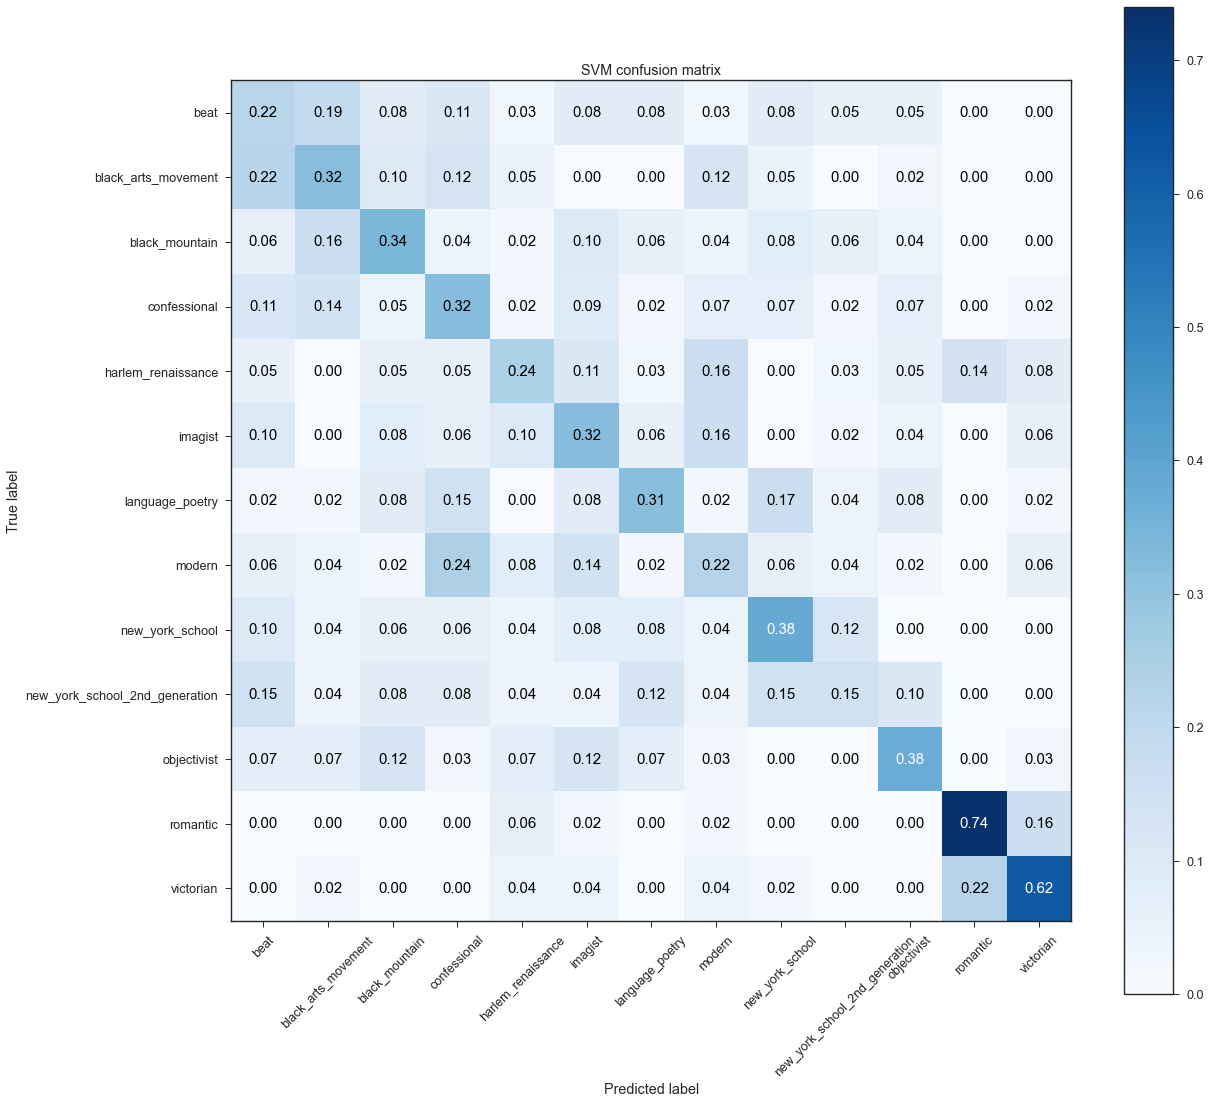

In [104]:
cm = confusion_matrix(y_test, y_test_preds_svm_doc2vec)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

In [129]:
# assign a features dataframe
X3 = pd.concat([df_downsampled[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'avg_syllables_word', 'string_cleaned']], df_vecs_downsampled], axis=1)
# assign a target variable
y3 = df_downsampled['genre']

In [132]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_vec_matrix = vectorizer.fit_transform(X3.string_cleaned)

In [133]:
# turn our tf-idf vectors into a dataframe so we can better view feature importances
X_word_vec = pd.DataFrame.sparse.from_spmatrix(X_vec_matrix, columns=vectorizer.get_feature_names())

In [136]:
X3.drop(columns='string_cleaned').shape, X_word_vec.shape

((2379, 106), (2379, 25283))

In [150]:
X3.drop(columns='string_cleaned').reset_index()

,index,num_lines,avg_len_line,sentiment_polarity_score,sentiment_subjectivity_score,num_end_rhymes,avg_syllables_word,0,1,2,...,90,91,92,93,94,95,96,97,98,99
0,0,4,6.000000,0.1779,0.680952,0,1.083333,2.281032,-1.371374,-2.219669,...,0.914341,-0.042474,-1.413320,3.378504,-0.387815,-0.327874,-0.029154,1.119749,2.482635,-2.202907
1,1,17,2.647059,-0.4588,0.512698,0,1.266667,2.165715,-2.016965,2.226701,...,-2.519491,-1.564618,2.388425,-3.334627,-2.866033,2.925122,-1.246679,0.222634,-2.713806,-0.705287
2,2,6,5.500000,0.3612,0.288889,1,1.242424,-0.847129,-3.568497,1.766024,...,-1.003638,1.122231,3.063076,-0.517507,-0.472288,1.351467,-1.488940,1.042941,0.121341,0.073162
3,3,17,3.176471,0.3506,0.787500,0,1.240741,-5.168643,-1.855756,1.614694,...,-0.311557,-3.424692,0.067995,3.414546,0.398550,-0.784360,-2.558453,3.444434,-1.373973,-2.202393
4,4,4,3.250000,0.0000,0.150000,0,1.230769,-1.217890,1.304392,-2.843359,...,-0.483795,1.881845,-1.505026,-1.484471,-2.559262,-1.319453,-0.751955,2.392272,-0.071207,-1.690263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,3808,14,8.214286,0.5060,0.466667,13,1.182609,-1.085928,-5.001645,1.206227,...,1.549566,5.036815,-2.781353,1.795333,0.512986,1.587189,5.032341,-0.050228,0.064698,0.690594
2375,3887,12,5.916667,0.9100,0.563095,6,1.169014,1.239201,-1.082733,2.758261,...,0.637942,9.972085,1.780657,1.189644,-0.548610,-3.380757,1.963030,-0.850747,5.563792,-6.904037
2376,4273,90,7.114754,0.9996,0.520693,50,1.101382,-3.652570,-2.258399,2.438614,...,3.975651,-0.572267,-1.837615,-0.209227,-1.130142,-5.440152,3.758914,0.042604,1.943431,-5.402403
2377,3817,90,7.841360,0.9999,0.461344,50,1.183887,-0.404934,-2.785555,2.529218,...,1.566773,1.870167,2.000752,2.193125,-0.242649,-3.517747,-0.405101,-2.780553,0.569990,-0.379538


In [151]:
X3b = pd.concat([X3.drop(columns='string_cleaned').reset_index(), X_word_vec], axis=1)

In [152]:
X3b.shape

(2379, 25390)

In [155]:
# train-test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3b, y3, stratify=y3, random_state=42)
print(X_train3.shape, y_train3.shape)
print(X_test3.shape, y_test3.shape)

(1784, 25390) (1784,)
(595, 25390) (595,)


In [156]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our numerical data
X_train_scaled = scaler.fit_transform(X_train3)
X_test_scaled = scaler.transform(X_test3)

In [157]:
%%time

# instantiate the model
svm_doc2vec = SVC(C=1, kernel='linear', class_weight='balanced')

# fit to the training set
svm_doc2vec.fit(X_train_scaled, y_train3)

CPU times: user 4min 4s, sys: 1.21 s, total: 4min 6s
Wall time: 4min 7s


SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [158]:
%%time

# predict class for the train and test sets
y_train_preds_svm_doc2vec = svm_doc2vec.predict(X_train_scaled)
y_test_preds_svm_doc2vec = svm_doc2vec.predict(X_test_scaled)

# print out accuracy and f1 scores for train set
svm_doc2vec_acc_train = accuracy_score(y_train3, y_train_preds_svm_doc2vec)
svm_doc2vec_f1_train = f1_score(y_train3, y_train_preds_svm_doc2vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_doc2vec_acc_train}')
print(f'F1 score: {svm_doc2vec_f1_train}')

# print out accuracy and f1 scores for test set
svm_doc2vec_acc_test = accuracy_score(y_test3, y_test_preds_svm_doc2vec)
svm_doc2vec_f1_test = f1_score(y_test3, y_test_preds_svm_doc2vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_doc2vec_acc_test}')
print(f'F1 score: {svm_doc2vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test3, y_test_preds_svm_doc2vec, target_names=list(y3.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test3, y_test_preds_svm_doc2vec))

-----TRAIN-----
Accuracy: 1.0
F1 score: 1.0

-----TEST-----
Accuracy: 0.6521008403361345
F1 score: 0.650760876102348

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.70      0.38      0.49        37
           black_arts_movement       0.50      0.46      0.48        41
                black_mountain       0.48      0.72      0.58        50
                  confessional       0.51      0.43      0.47        44
            harlem_renaissance       0.62      0.57      0.59        37
                       imagist       0.57      0.70      0.63        50
               language_poetry       0.64      0.58      0.61        48
                        modern       0.61      0.66      0.63        50
               new_york_school       0.74      0.70      0.72        50
new_york_school_2nd_generation       0.65      0.73      0.

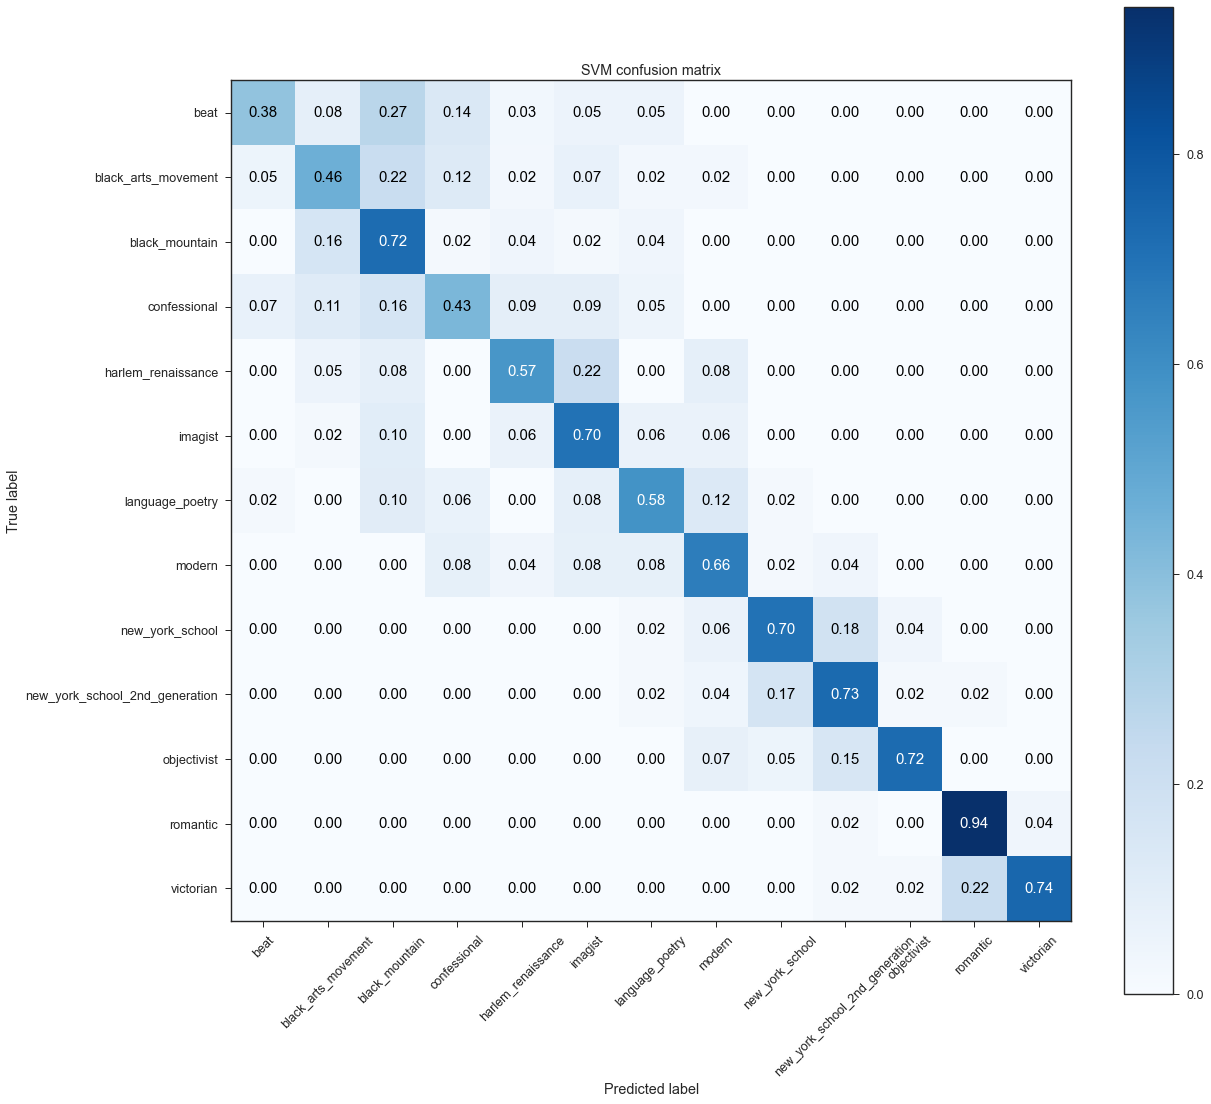

In [159]:
cm = confusion_matrix(y_test, y_test_preds_svm_doc2vec)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

In [183]:
%%time

# instantiate the model
svm_doc2vec2 = SVC(C=.1,
                   kernel='linear',
#                    class_weight='balanced',
                   random_state=42)

# fit to the training set
svm_doc2vec2.fit(X_train_scaled, y_train3)

CPU times: user 3min 29s, sys: 802 ms, total: 3min 30s
Wall time: 3min 31s


SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [184]:
%%time

# predict class for the train and test sets
y_train_preds_svm_doc2vec2 = svm_doc2vec2.predict(X_train_scaled)
y_test_preds_svm_doc2vec2 = svm_doc2vec2.predict(X_test_scaled)

# print out accuracy and f1 scores for train set
svm_doc2vec_acc_train2 = accuracy_score(y_train3, y_train_preds_svm_doc2vec2)
svm_doc2vec_f1_train2 = f1_score(y_train3, y_train_preds_svm_doc2vec2, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_doc2vec_acc_train2}')
print(f'F1 score: {svm_doc2vec_f1_train2}')

# print out accuracy and f1 scores for test set
svm_doc2vec_acc_test2 = accuracy_score(y_test3, y_test_preds_svm_doc2vec2)
svm_doc2vec_f1_test2 = f1_score(y_test3, y_test_preds_svm_doc2vec2, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_doc2vec_acc_test2}')
print(f'F1 score: {svm_doc2vec_f1_test2}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test3, y_test_preds_svm_doc2vec2, target_names=list(y3.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test3, y_test_preds_svm_doc2vec2))

-----TRAIN-----
Accuracy: 0.999439461883408
F1 score: 0.9994396580100507

-----TEST-----
Accuracy: 0.6571428571428571
F1 score: 0.6545211568581314

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.70      0.38      0.49        37
           black_arts_movement       0.51      0.44      0.47        41
                black_mountain       0.52      0.76      0.62        50
                  confessional       0.53      0.43      0.48        44
            harlem_renaissance       0.61      0.51      0.56        37
                       imagist       0.51      0.72      0.60        50
               language_poetry       0.67      0.58      0.62        48
                        modern       0.59      0.70      0.64        50
               new_york_school       0.73      0.70      0.71        50
new_york_school_2nd_generatio

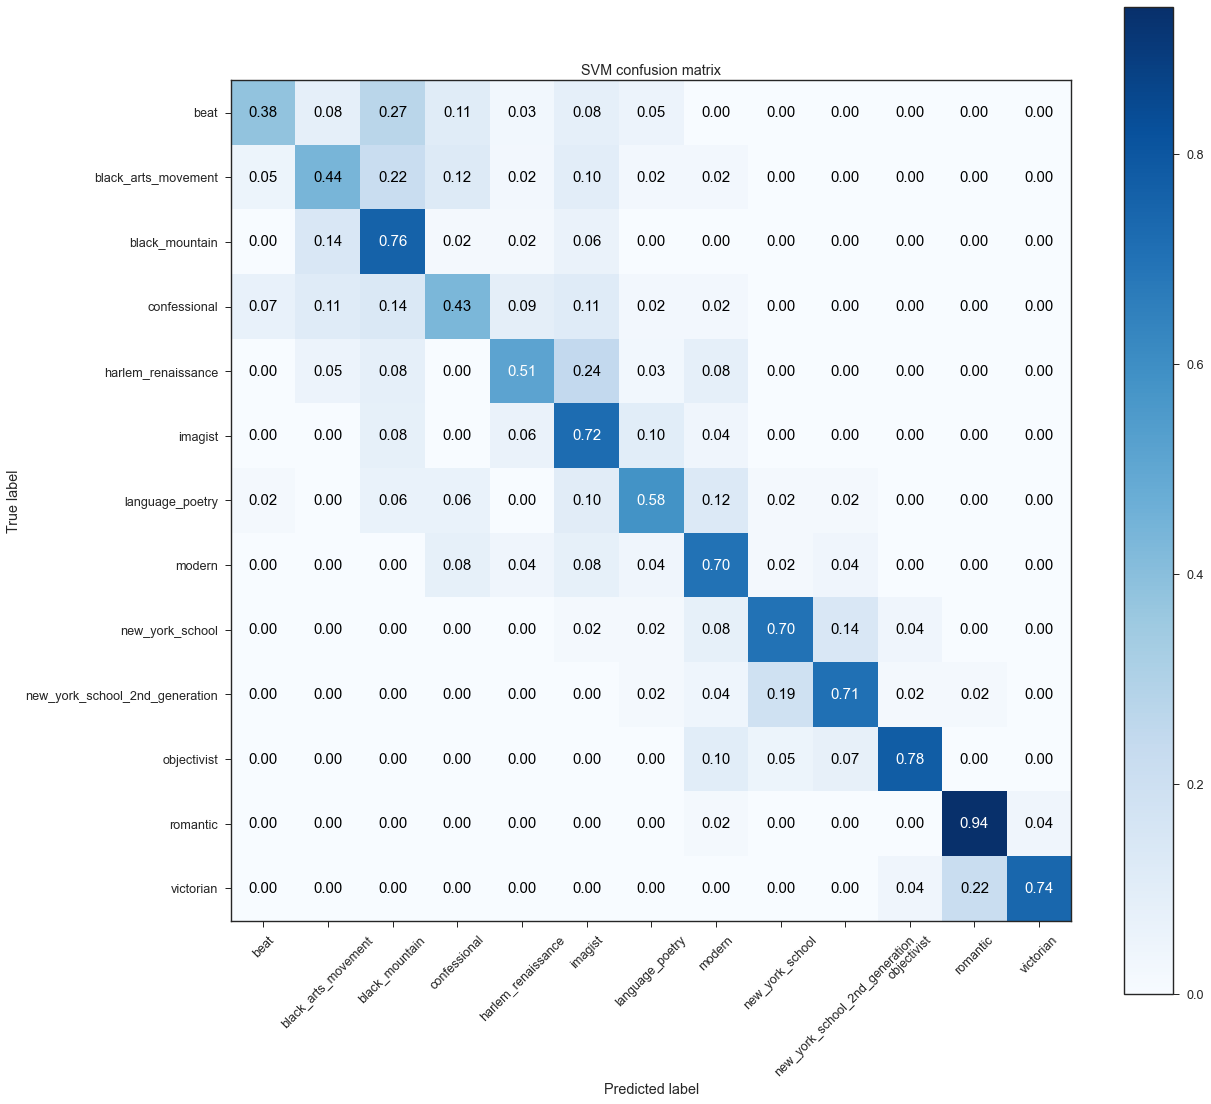

In [185]:
cm = confusion_matrix(y_test, y_test_preds_svm_doc2vec2)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

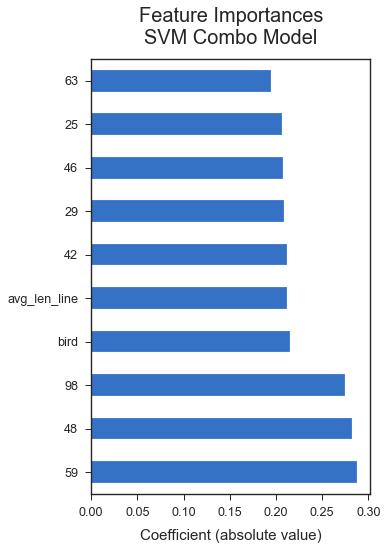

In [186]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_doc2vec2.coef_[0]), index=X_train3.columns).nlargest(10).plot(kind='barh');